### BDP Final Project: Twitter Credibility Analysis on Special Education - Part 2-2: Influencial Tweeterer

In [1]:
spark.version

'3.1.3'

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')

import warnings
warnings.filterwarnings(action='ignore')
warnings.simplefilter('ignore')

from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,isnan,when,count
import matplotlib.pyplot as plt
spark.conf.set("spark.sql.debug.maxToStringFields", 1000)

In [3]:
# List all files in given COS directory
def list_blobs_pd(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix=folder_name))

    blob_name = []
    blob_size = []
    
    for blob in blobs:
        blob_name.append(blob.name)
        blob_size.append(blob.size)

    blobs_df = pd.DataFrame(list(zip(blob_name, blob_size)), columns=['Name','Size'])

    blobs_df.style.format({"Size": "{:,.0f}"}) 
    
    return blobs_df

In [4]:
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [5]:
# folder_write = 'shared_data/chihhan/final_project_part2_V1'

In [6]:
path = 'gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part2_V1'

In [7]:
edu_df = spark.read.parquet(path)

In [8]:
edu_df.limit(5)

tweet_id,tweet_likes,time_tweet_created,tweet_reply_count,language,tweet_text,user_id,user_name,user_description,user_followers_count,user_like_count,verified_user,time_account_created,location,country_name,country_code,is_retweeted,retweeted_from,rt_created_time,rt_likes,rt_count,rt_reply_count,rt_hashtags,rt_usr_id,rt_id,original_tweet
1597115277602430981,0,Mon Nov 28 06:28:...,0,en,happy total secti...,1587123926022656000,Priscilla Harris,the same items fr...,110,531,false,Mon Oct 31 16:47:...,null,null,null,false,null,null,null,null,null,null,null,null,true
1597115281717227521,0,Mon Nov 28 06:28:...,0,en,#rc16 graduation ...,1512661462438752265,Suguna College of...,Suguna College of...,2,0,false,Sat Apr 09 05:53:...,null,null,null,false,null,null,null,null,null,null,null,null,true
1597115288541331456,0,Mon Nov 28 06:28:...,0,en,#卡塔尔世界杯 #世界杯下注 ht...,1530512461220257792,天博体育 AOA体育 开云体育 世...,AOA体育http://aoa85...,0,0,false,Sat May 28 11:33:...,null,null,null,false,null,null,null,null,null,null,null,null,true
1597115289325314049,0,Mon Nov 28 06:28:...,0,en,use of any relati...,1587149413054570497,Kimberly Olson,last day i found ...,110,592,false,Mon Oct 31 18:28:...,null,null,null,false,null,null,null,null,null,null,null,null,true
1597115289950638080,0,Mon Nov 28 06:28:...,0,en,i’m finally gradu...,389316573,c__c,Love you to the m...,60,26599,false,Wed Oct 12 06:30:...,null,null,null,true,yadarilya,Mon Nov 28 04:58:...,98,26,9,[],1405450842199654404,1597092424912097280,false


In [9]:
edu_df.count()

33490185

In [10]:
path2 = 'gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part2_2'

In [11]:
tweeter_cat = spark.read.parquet(path2)

In [12]:
tweeter_cat.limit(5)

tweet_id,tweet_likes,time_tweet_created,tweet_reply_count,language,tweet_text,user_id,user_name,user_description,user_followers_count,user_like_count,verified_user,time_account_created,location,country_name,country_code,is_retweeted,retweeted_from,rt_created_time,rt_likes,rt_count,rt_reply_count,rt_hashtags,rt_usr_id,rt_id,original_tweet,twitterer_catogory
1514974123751088133,0,Fri Apr 15 14:29:...,0,en,join us 4/25 for ...,1189250547355811840,mit.nano,we measure the fu...,1522,1501,false,Tue Oct 29 18:40:...,null,null,null,false,null,null,null,null,null,null,null,null,true,other
1514974131434971140,0,Fri Apr 15 14:29:...,0,en,a teacher for mor...,819662390149214208,dan marshall,ontario correctio...,243,11515,false,Thu Jan 12 21:48:...,null,null,null,true,EAlexander46,Fri Apr 15 13:12:...,231,54,9,[],1351258907113648128,1514954830141399040,false,other
1514974131766366210,0,Fri Apr 15 14:29:...,0,en,my intro to polit...,312384480,taylor brown,christian. @oksta...,1862,38201,false,Tue Jun 07 01:40:...,null,null,null,false,null,null,null,null,null,null,null,null,true,other
1514974133758861315,0,Fri Apr 15 14:29:...,0,en,covid is back aga...,1075449971623714816,bhukya khethavath...,just keep working...,609,12582,false,Wed Dec 19 17:57:...,null,null,null,true,anubha1812,Thu Apr 14 15:11:...,993,598,147,[],159060077,1514622485248954372,false,other
1514974133918085129,0,Fri Apr 15 14:29:...,0,en,nevada basketball...,1021833553829613573,nevada sports net,your go-to source...,7348,3516,true,Tue Jul 24 19:04:...,null,null,null,true,ByChrisMurray,Fri Apr 15 14:28:...,0,2,0,[],40287046,1514973870847332356,false,other


In [13]:
tweeter_cat.count()

27566156

In [14]:
tweeter_cat.printSchema()

root
 |-- tweet_id: long (nullable = true)
 |-- tweet_likes: long (nullable = true)
 |-- time_tweet_created: string (nullable = true)
 |-- tweet_reply_count: long (nullable = true)
 |-- language: string (nullable = true)
 |-- tweet_text: string (nullable = true)
 |-- user_id: long (nullable = true)
 |-- user_name: string (nullable = true)
 |-- user_description: string (nullable = true)
 |-- user_followers_count: long (nullable = true)
 |-- user_like_count: long (nullable = true)
 |-- verified_user: boolean (nullable = true)
 |-- time_account_created: string (nullable = true)
 |-- location: string (nullable = true)
 |-- country_name: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- is_retweeted: boolean (nullable = true)
 |-- retweeted_from: string (nullable = true)
 |-- rt_created_time: string (nullable = true)
 |-- rt_likes: long (nullable = true)
 |-- rt_count: long (nullable = true)
 |-- rt_reply_count: long (nullable = true)
 |-- rt_hashtags: array (nullabl

In [15]:
# twitterer_cat_data = spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part2_2')

####  **2.1 Identify the most prolific / influential Twitterers**

##### **By message volume (original content)**

In [16]:
edu_df.select('user_id', 'original_tweet').filter(col('original_tweet') == True).\
groupby('user_id').count().sort(col('count').desc())

user_id,count
219401992,9284
66263683,8264
1426164518581899266,7337
1549115944735481856,7333
1272479318447230977,6953
1434562949381767177,5597
1448701295318216704,4551
1448410354363551747,4485
1170532065965555712,4268
1389966784527147008,3926


In [17]:
tweeter_cat.select('user_id', 'user_name', 'user_description', 'twitterer_catogory').filter(col('original_tweet') == True).filter(col('user_id') == 219401992)

user_id,user_name,user_description,twitterer_catogory
219401992,dennis stemmle,founder - college...,schools
219401992,dennis stemmle,founder - college...,schools
219401992,dennis stemmle,founder - college...,schools
219401992,dennis stemmle,founder - college...,schools
219401992,dennis stemmle,founder - college...,schools
219401992,dennis stemmle,founder - college...,schools
219401992,dennis stemmle,founder - college...,schools
219401992,dennis stemmle,founder - college...,schools
219401992,dennis stemmle,founder - college...,schools
219401992,dennis stemmle,founder - college...,schools


- **Who are these Twitterers ?**  
(government entities / universities / schools / nonprofit organizations / news outlets / social media influencers / someone else)

In [18]:
top_20 = tweeter_cat.select('user_id', 'user_name','twitterer_catogory').filter(col('original_tweet') == True).\
groupby('user_id', 'user_name', 'twitterer_catogory').count().sort(col('count').desc()).toPandas()[:20]

In [19]:
top_20 

,user_id,user_name,twitterer_catogory,count
0,219401992,dennis stemmle,schools,9284
1,66263683,njschooljobs.com,other,8264
2,1426164518581899266,"accepting light,urgent commissions",other,7091
3,1272479318447230977,a random user,other,6953
4,1434562949381767177,edibeeee,other,5597
5,1448701295318216704,sexual assault bot,ngo,4551
6,1170532065965555712,men's fashion tv 〜メンズファッションテレビ〜,other,4268
7,1389966784527147008,keen,other,3926
8,25739661,prepstar,other,3762
9,2868388510,sportsthread,schools,3157


In [20]:
top_20[['user_name', 'twitterer_catogory', 'count']]

,user_name,twitterer_catogory,count
0,dennis stemmle,schools,9284
1,njschooljobs.com,other,8264
2,"accepting light,urgent commissions",other,7091
3,a random user,other,6953
4,edibeeee,other,5597
5,sexual assault bot,ngo,4551
6,men's fashion tv 〜メンズファッションテレビ〜,other,4268
7,keen,other,3926
8,prepstar,other,3762
9,sportsthread,schools,3157


- **Visualize the distribution of tweet / retweet volume by Twitterers and types of organizations**

Text(0.5, 1.0, 'Top 20 Influential Tweeters by Original Tweets Counts & Organizations')

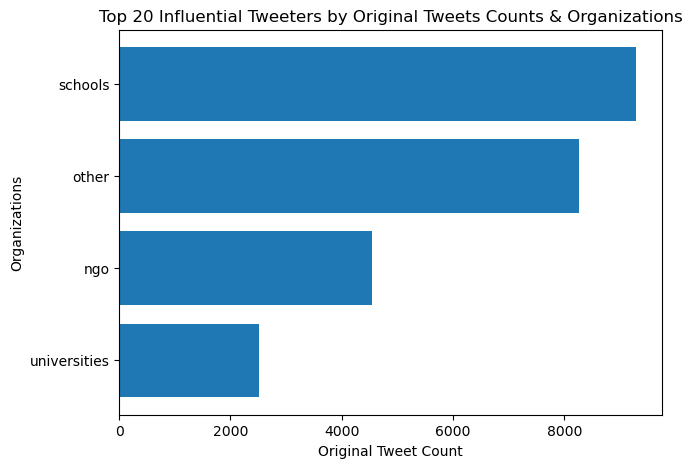

In [21]:
fig, ax = plt.subplots(figsize =(7, 5)) 
ax.barh(top_20['twitterer_catogory'], top_20['count'])
ax.invert_yaxis()
plt.xlabel('Original Tweet Count')
plt.ylabel('Organizations')
plt.title('Top 20 Influential Tweeters by Original Tweets Counts & Organizations')

Text(0.5, 1.0, 'Top 20 Influential Tweeters by Original Tweets Counts')

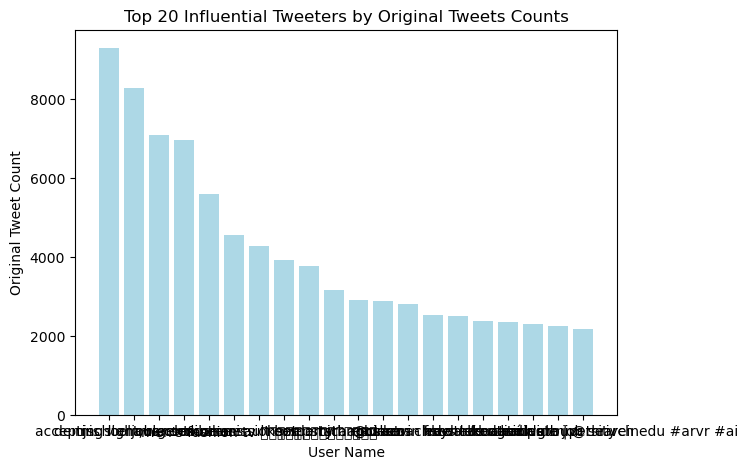

In [22]:
fig, ax = plt.subplots(figsize =(7, 5)) 
ax.bar(top_20['user_name'], top_20['count'], color='lightblue')
# ax.tick_params(axis=top_20['user_name'], rotation=90)
plt.xlabel('User Name')
plt.ylabel('Original Tweet Count')
plt.title('Top 20 Influential Tweeters by Original Tweets Counts')

Text(0.5, 1.0, 'Top 20 Influential Tweeters by Original Tweets Counts')

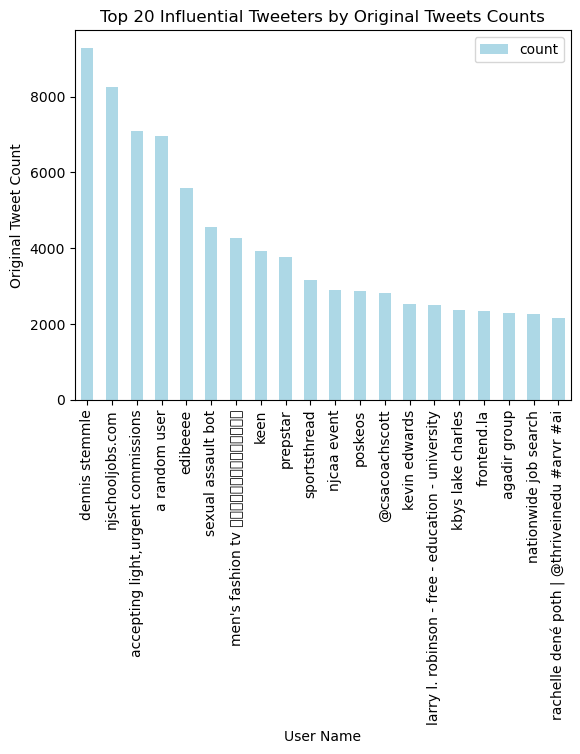

In [23]:
ax = top_20.plot(kind = 'bar', x = 'user_name', y = 'count', color='lightblue')
ax.set_xlabel('User Name')
ax.set_ylabel('Original Tweet Count')
ax.set_title('Top 20 Influential Tweeters by Original Tweets Counts')

In [24]:
top_20['user_id']

0               219401992
1                66263683
2     1426164518581899266
3     1272479318447230977
4     1434562949381767177
5     1448701295318216704
6     1170532065965555712
7     1389966784527147008
8                25739661
9              2868388510
10    1562234314339012610
11    1554982001156947969
12    1325900968911798272
13    1408202907149815809
14     753215841655746560
15             1337927119
16     875107384535900161
17    1492515474055348224
18    1101270461986496512
19               49860518
Name: user_id, dtype: int64

In [25]:
top_20_user_id = list(top_20['user_id'])
top_20_user_id

[219401992,
 66263683,
 1426164518581899266,
 1272479318447230977,
 1434562949381767177,
 1448701295318216704,
 1170532065965555712,
 1389966784527147008,
 25739661,
 2868388510,
 1562234314339012610,
 1554982001156947969,
 1325900968911798272,
 1408202907149815809,
 753215841655746560,
 1337927119,
 875107384535900161,
 1492515474055348224,
 1101270461986496512,
 49860518]

In [26]:
top_20_original_user_profile = tweeter_cat.filter((tweeter_cat.user_id.isin(top_20_user_id))).filter(col('original_tweet') == True).\
select('user_id', 'user_name', 'user_description', 'twitterer_catogory')

In [27]:
top_20_original_user_profile = top_20_original_user_profile.toPandas()

In [28]:
top_20_original_user_profile

,user_id,user_name,user_description,twitterer_catogory
0,753215841655746560,larry l. robinson - free - education - university,is a 17 course curriculum that teaches you how to find the right financial opportunities to fund your higher education https://tinyurl.com/y295tofh,schools
1,753215841655746560,larry l. robinson - free - education - university,is a 17 course curriculum that teaches you how to find the right financial opportunities to fund your higher education https://tinyurl.com/y295tofh,schools
2,66263683,njschooljobs.com,the leading advertiser of education jobs for new jersey's schools since 1999! #nj #teaching #administrative #coaching #education #teachingjobs #newjersey,other
3,66263683,njschooljobs.com,the leading advertiser of education jobs for new jersey's schools since 1999! #nj #teaching #administrative #coaching #education #teachingjobs #newjersey,other
4,1554982001156947969,poskeos,"""something like new medicine was my apology in year 2013..."" 《2013for (4) 2023five×(⌚⏳2)sheadoffice》",other
...,...,...,...,...
82128,1272479318447230977,a random user,"i am not a bot believe me\n\ni tweet about random things , expect the unexpected!",other
82129,219401992,dennis stemmle,"founder - college success academy, #1 best-selling author, entrepreneur, speaker, lecturer at the wall college of business - coastal carolina university",schools
82130,49860518,rachelle dené poth | @thriveinedu #arvr #ai,💥iste certified educator |teacher| consultant| speaker| attorney | author blogger |past-pres #isteten | buncee |nearpod #pionear| 💥#thriveinedu 💜📚,universities
82131,875107384535900161,frontend.la,please donate some $doge @ d7sz2qubuzdvqet34vm1v5ezsrcfnn4ep2,other


In [29]:
top_20_original_user_profile = top_20_original_user_profile.drop_duplicates('user_id')

In [30]:
top_20_original_user_profile['user_id'].unique()

array([ 753215841655746560,            66263683, 1554982001156947969,
       1170532065965555712,           219401992, 1101270461986496512,
                1337927119,            49860518, 1448701295318216704,
        875107384535900161, 1272479318447230977, 1434562949381767177,
       1325900968911798272,            25739661, 1492515474055348224,
                2868388510, 1426164518581899266, 1408202907149815809,
       1562234314339012610, 1389966784527147008])

In [31]:
sorted_df_original = top_20_original_user_profile.groupby('twitterer_catogory', sort=False).count()
sorted_df_original

,user_id,user_name,user_description
twitterer_catogory,,,
schools,4,4,4
other,12,12,12
universities,2,2,2
ngo,2,2,2


In [32]:
top_20_original_user_profile[['user_name', 'user_description', 'twitterer_catogory']]

,user_name,user_description,twitterer_catogory
0,larry l. robinson - free - education - university,is a 17 course curriculum that teaches you how to find the right financial opportunities to fund your higher education https://tinyurl.com/y295tofh,schools
2,njschooljobs.com,the leading advertiser of education jobs for new jersey's schools since 1999! #nj #teaching #administrative #coaching #education #teachingjobs #newjersey,other
4,poskeos,"""something like new medicine was my apology in year 2013..."" 《2013for (4) 2023five×(⌚⏳2)sheadoffice》",other
5,men's fashion tv 〜メンズファッションテレビ〜,we like suits.we like outdoor fashion and sneakers too.\nスーツも好きだけどアウトドアもスニーカーも好き。,other
15,dennis stemmle,"founder - college success academy, #1 best-selling author, entrepreneur, speaker, lecturer at the wall college of business - coastal carolina university",schools
18,nationwide job search,find local jobs now.,other
19,kbys lake charles,#mcneese #geauxpokes #lakecharles #supportlocal http://www.kbys.fm,other
20,rachelle dené poth | @thriveinedu #arvr #ai,💥iste certified educator |teacher| consultant| speaker| attorney | author blogger |past-pres #isteten |#mieexpert |nearpod #pionear| 💥#thriveinedu 💜📚,universities
21,sexual assault bot,raising awareness for sexual assault prevention. resources and facts are posted daily.,ngo
24,frontend.la,please donate some $doge @ d7sz2qubuzdvqet34vm1v5ezsrcfnn4ep2,other


In [ ]:
# top_20_original = tweeter_cat.filter((tweeter_cat.user_id.isin(top_20_user_id))).filter(col('original_tweet') == True).\
# select('user_id', 'user_name', 'user_description', 'twitterer_catogory','user_followers_count').count().sort(col('count').desc()).toPandas()

In [ ]:
# fig, ax = plt.subplots(figsize =(7, 5)) 
# ax.barh(top_20_total['twitterer_catogory'], top_20_total['user_followers_count'])
# ax.invert_yaxis()
# plt.xlabel('Total Tweet Count')
# plt.ylabel('Organizations')
# plt.title('Top 20 Organizations by Total Tweets Regarding Special Education')

In [ ]:
# top_20_original = tweeter_cat.select('user_id', 'user_name','twitterer_catogory').filter(col('original_tweet') == True).\
# groupby('user_id', 'user_name', 'twitterer_catogory').count().sort(col('count').desc()).toPandas()[:20]

In [ ]:
# top_20_original

In [ ]:
# fig, ax = plt.subplots(figsize =(7, 5)) 
# ax.barh(top_20_original['twitterer_catogory'], top_20_original['count'])
# ax.invert_yaxis()
# plt.xlabel('Original Tweet Count')
# plt.ylabel('Organizations')
# plt.title('Top 20 Organizations by Amount of Original Tweets Regarding Special Education')

In [ ]:
# # eliminate others
# top_20_original_no_other = tweeter_cat.select('user_id', 'user_name','twitterer_catogory').filter(col('original_tweet') == True).\
# .filter(col('twitterer_catogory') != 'other').groupby('user_id', 'user_name', 'twitterer_catogory').count().sort(col('count').desc()).toPandas()[:20]
# top_20_original_no_other

In [ ]:
# fig, ax = plt.subplots(figsize =(7, 5)) 
# ax.barh(top_20_original_no_otherl['twitterer_catogory'], top_20_original_no_other['count'])
# ax.invert_yaxis()
# plt.xlabel('Original Tweet Count')
# plt.ylabel('Organizations')
# plt.title('Top 20 Organizations by Original Tweets Counts (Exclude Other category)')

##### **By message retweet (how often their messages are being retweeted)**

In [33]:
edu_df.select('user_id', 'is_retweeted').filter(col('is_retweeted') == True).\
groupby('user_id').count().sort(col('count').desc())

user_id,count
1038107559817830400,6567
1295715136141963267,5527
152936614,4778
1499577679401603089,3859
1311337818518556672,3672
1129718312466812930,3629
3224986553,2559
38321921,2072
115055995,1892
1164502444472033280,1810


In [34]:
edu_df.select('user_id', 'user_name' , 'is_retweeted').filter(col('is_retweeted') == True).\
groupby('user_id', 'user_name').count().sort(col('count').desc())

user_id,user_name,count
1038107559817830400,James Clark,6567
1295715136141963267,Education World,5527
152936614,Joe Windon,4778
1499577679401603089,Educationbnb,3859
1311337818518556672,Academic Opportun...,3672
1129718312466812930,Rosina O,3629
3224986553,College Esports,2559
1164502444472033280,NSS RD Chandigarh,1810
1491776087684104193,Jobs via Tweet,1766
1039965688000126977,Mark Johnson,1761


In [35]:
top_20_retweet = tweeter_cat.select('user_id', 'user_name' , 'is_retweeted').filter(col('is_retweeted') == True).\
groupby('user_id', 'user_name').count().sort(col('count').desc())

In [36]:
top_20_retweet

user_id,user_name,count
1038107559817830400,james clark,6567
1295715136141963267,education world,5527
152936614,joe windon,4778
1499577679401603089,educationbnb,3859
1311337818518556672,academic opportun...,3672
1129718312466812930,rosina o,3629
3224986553,college esports,2559
1164502444472033280,nss rd chandigarh,1810
1491776087684104193,jobs via tweet,1766
1039965688000126977,mark johnson,1761


In [ ]:
# top_20 = tweeter_cat.select('user_id', 'user_name','twitterer_catogory').filter(col('original_tweet') == True).\
# groupby('user_id', 'user_name', 'twitterer_catogory').count().sort(col('count').desc()).toPandas()[:20]

In [ ]:
# top_20_retweet = tweeter_cat.select('user_id', 'user_name', 'twitterer_catogory').filter(col('is_retweeted') == True).\
# groupby('user_id', 'user_name', 'twitterer_catogory').count().sort(col('count').desc()).toPandas()[:20]

In [ ]:
# top_20_retweet

In [ ]:
# fig, ax = plt.subplots(figsize =(7, 5)) 
# ax.barh(top_20_retweet['twitterer_catogory'], top_20_retweet['count'])
# ax.invert_yaxis()
# plt.xlabel('Retweet Count')
# plt.ylabel('Organizations')
# plt.title('Top 20 Organizations by Retweet Counts Regarding Special Education')

- **Who are these Twitterers ?**  
(government entities / universities / schools / nonprofit organizations / news outlets / social media influencers / someone else)

In [37]:
top_20_retweet2 = tweeter_cat.select('user_id', 'user_name', 'twitterer_catogory').filter(col('is_retweeted') == True).\
groupby('user_id', 'user_name', 'twitterer_catogory').count().sort(col('count').desc())

In [38]:
top_20_retweet2

user_id,user_name,twitterer_catogory,count
1038107559817830400,james clark,other,6567
1295715136141963267,education world,other,5527
152936614,joe windon,other,4778
1499577679401603089,educationbnb,other,3859
1311337818518556672,academic opportun...,ngo,3672
1129718312466812930,rosina o,universities,3629
3224986553,college esports,schools,2559
1164502444472033280,nss rd chandigarh,government_entities,1810
1491776087684104193,jobs via tweet,other,1766
1039965688000126977,mark johnson,other,1761


In [ ]:
top_20_retweet2 = top_20_retweet2.toPandas()[:20]

In [ ]:
top_20_retweet2[['user_name', 'twitterer_catogory', 'count']]

,user_name,twitterer_catogory,count
0,james clark,other,6567
1,education world,other,5527
2,joe windon,other,4778
3,educationbnb,other,3859
4,academic opportunities,ngo,3672
5,rosina o,universities,3629
6,college esports,schools,2559
7,nss rd chandigarh,government_entities,1810
8,jobs via tweet,other,1766
9,mark johnson,other,1761


In [ ]:
top_20_retweet2['user_name']

0                          james clark
1                      education world
2                           joe windon
3                         educationbnb
4               academic opportunities
5                             rosina o
6                      college esports
7                    nss rd chandigarh
8                       jobs via tweet
9                         mark johnson
10                         adam gorney
11                         barry every
12                  corey a. deangelis
13                               bobby
14             1158aplcneeraj parjapti
15                        babe perales
16                     developer bot 🤖
17    ms. barnett's kindergarten class
18                          lisa drees
19                            03/07 ♓♓
Name: user_name, dtype: object

In [ ]:
top_20_retweet2_user_id = list(top_20_retweet2['user_id'])
top_20_retweet2_user_id

[1038107559817830400,
 1295715136141963267,
 152936614,
 1499577679401603089,
 1311337818518556672,
 1129718312466812930,
 3224986553,
 1164502444472033280,
 1491776087684104193,
 1039965688000126977,
 19566259,
 581197320,
 1276140426,
 996825409428717568,
 1505135745065177089,
 1463973734998585344,
 1437728609909706753,
 1548696289881227267,
 31007311,
 38321921]

In [ ]:
top_20_retweets_user_profile = tweeter_cat.filter((tweeter_cat.user_id.isin(top_20_retweet2_user_id))).filter(col('is_retweeted') == True).\
select('user_id', 'user_name', 'user_description', 'twitterer_catogory')

In [ ]:
top_20_retweets_user_profile = top_20_retweets_user_profile.toPandas()

In [ ]:
top_20_retweets_user_profile

,user_id,user_name,user_description,twitterer_catogory
0,1491776087684104193,jobs via tweet,one stop destination for job search on twitter.,other
1,1311337818518556672,academic opportunities,just trying to help spread the word about academic jobs and funding opportunities. tell me about your postings and i'll amplify.,ngo
2,1311337818518556672,academic opportunities,just trying to help spread the word about academic jobs and funding opportunities. tell me about your postings and i'll amplify.,ngo
3,1311337818518556672,academic opportunities,just trying to help spread the word about academic jobs and funding opportunities. tell me about your postings and i'll amplify.,ngo
4,1311337818518556672,academic opportunities,just trying to help spread the word about academic jobs and funding opportunities. tell me about your postings and i'll amplify.,ngo
...,...,...,...,...
51350,1039965688000126977,mark johnson,assistant manager at @k12prospects. k-12 educational sales and marketing. connecting with educators. business opportunities.\n#edtech #education #data,other
51351,1039965688000126977,mark johnson,assistant manager at @k12prospects. k-12 educational sales and marketing. connecting with educators. business opportunities.\n#edtech #education #data,other
51352,152936614,joe windon,national preps director of south east scouting 706-615-2824 athletes add yourself to the national preps database https://tinyurl.com/2p89y6ub,other
51353,1499577679401603089,educationbnb,by doctor @krittanawongmd. the leaderboard of #education3.0 lovers. our mission: establish education 3.0 twitter community,other


In [ ]:
top_20_retweets_user_profile = top_20_retweets_user_profile.drop_duplicates('user_id')

In [ ]:
top_20_retweets_user_profile

,user_id,user_name,user_description,twitterer_catogory
0,1491776087684104193,jobs via tweet,one stop destination for job search on twitter.,other
1,1311337818518556672,academic opportunities,just trying to help spread the word about academic jobs and funding opportunities. tell me about your postings and i'll amplify.,ngo
9,1499577679401603089,educationbnb,by doctor @krittanawongmd. the leaderboard of #education3.0 lovers. our mission: establish education 3.0 twitter community,other
10,581197320,barry every,"ga, tn, va, wv scout for catapult sports. with over 250 college clients! paid by colleges & free to hs prospects. free survey link below ⬇",schools
11,1505135745065177089,1158aplcneeraj parjapti,assistant professor,schools
12,1295715136141963267,education world,all education content. education changes the life.\nsoftware developer| ml | ds | technical blogging at http://techmorf.com |,other
14,152936614,joe windon,national preps director of south east scouting 706-615-2824 athletes add yourself to the national preps database https://tinyurl.com/2p89y6ub,other
15,1039965688000126977,mark johnson,assistant manager at @k12prospects. k-12 educational sales and marketing. connecting with educators. business opportunities.\n#edtech #education #data,other
17,1038107559817830400,james clark,data quality professional. member of the @k12prospects data quality team. delivering the most accurate data of all schools and districts nationwide.,other
26,1129718312466812930,rosina o,"4th grade elementary school teacher, love to infuse technology into all content areas https://www.donorschoose.org/classroom/2384640?cachebust=1660824185553&utm",universities


In [ ]:
top_20_retweets_user_profile['user_id'].unique()

array([1491776087684104193, 1311337818518556672, 1499577679401603089,
                 581197320, 1505135745065177089, 1295715136141963267,
                 152936614, 1039965688000126977, 1038107559817830400,
       1129718312466812930,            38321921, 1437728609909706753,
                  19566259, 1164502444472033280, 1548696289881227267,
                3224986553,          1276140426,  996825409428717568,
                  31007311, 1463973734998585344])

In [ ]:
sorted_df = top_20_retweets_user_profile.groupby('twitterer_catogory', sort=False).count()
sorted_df

,user_id,user_name,user_description
twitterer_catogory,,,
other,8,8,8
ngo,1,1,1
schools,4,4,4
universities,4,4,4
Influencer,2,2,2
government_entities,1,1,1


In [ ]:
top_20_retweets_user_profile[['user_name', 'user_description', 'twitterer_catogory']]

,user_name,user_description,twitterer_catogory
0,jobs via tweet,one stop destination for job search on twitter.,other
1,academic opportunities,just trying to help spread the word about academic jobs and funding opportunities. tell me about your postings and i'll amplify.,ngo
9,educationbnb,by doctor @krittanawongmd. the leaderboard of #education3.0 lovers. our mission: establish education 3.0 twitter community,other
10,barry every,"ga, tn, va, wv scout for catapult sports. with over 250 college clients! paid by colleges & free to hs prospects. free survey link below ⬇",schools
11,1158aplcneeraj parjapti,assistant professor,schools
12,education world,all education content. education changes the life.\nsoftware developer| ml | ds | technical blogging at http://techmorf.com |,other
14,joe windon,national preps director of south east scouting 706-615-2824 athletes add yourself to the national preps database https://tinyurl.com/2p89y6ub,other
15,mark johnson,assistant manager at @k12prospects. k-12 educational sales and marketing. connecting with educators. business opportunities.\n#edtech #education #data,other
17,james clark,data quality professional. member of the @k12prospects data quality team. delivering the most accurate data of all schools and districts nationwide.,other
26,rosina o,"4th grade elementary school teacher, love to infuse technology into all content areas https://www.donorschoose.org/classroom/2384640?cachebust=1660824185553&utm",universities


- **Visualize the distribution of tweet / retweet volume by Twitterers and types of organizations**

In [ ]:
# fig, ax = plt.subplots(figsize =(9, 7)) 
# ax.plot(top_20_retweet2['user_name'], top_20_retweet2['count'])
# plt.xlabel('User Name')
# plt.ylabel('Retweet Count')
# plt.title('Top 20 Influential Tweeters by Retweet Counts')

Text(0.5, 1.0, 'Top 20 Influential Tweeters by Retweet Counts')

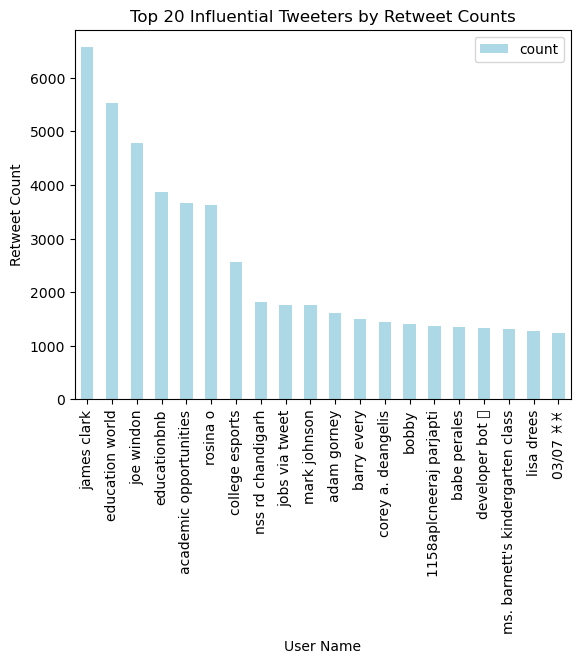

In [ ]:
ax = top_20_retweet2.plot(kind = 'bar', x = 'user_name', y = 'count', color='lightblue')
ax.set_xlabel('User Name')
ax.set_ylabel('Retweet Count')
ax.set_title('Top 20 Influential Tweeters by Retweet Counts')

In [ ]:
# fig, ax = plt.subplots(figsize =(9, 7)) 
# ax.plot(top_20_retweet2['user_name'], top_20_retweet2['count'])
# plt.xlabel('User Name')
# plt.ylabel('Retweet Count')
# plt.title('Top 20 Influential Tweeters by Retweet Counts')

Text(0.5, 1.0, 'Top 20 Influential Tweeters by Retweet Counts & Organizations')

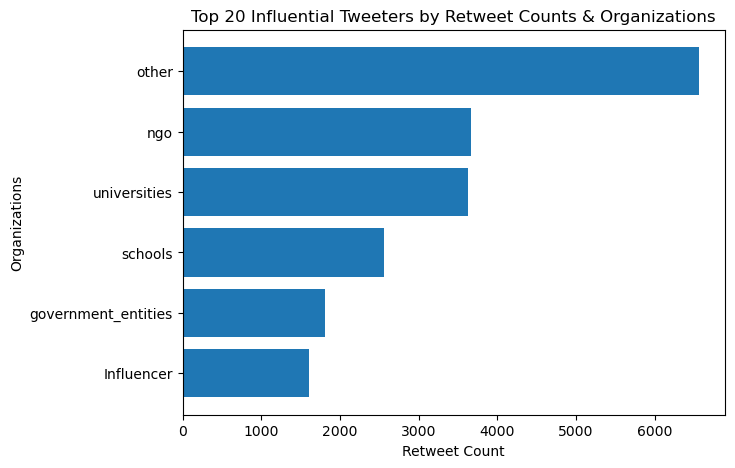

In [ ]:
fig, ax = plt.subplots(figsize =(7, 5)) 
ax.barh(top_20_retweet2['twitterer_catogory'], top_20_retweet2['count'])
ax.invert_yaxis()
plt.xlabel('Retweet Count')
plt.ylabel('Organizations')
plt.title('Top 20 Influential Tweeters by Retweet Counts & Organizations')

In [ ]:
# top_20_retweet = tweeter_cat.filter((tweeter_cat.user_id.isin(top_20_user_id))).filter(col('original_tweet') == True).\
# select('user_id', 'user_name', 'user_description', 'twitterer_catogory','user_followers_count').count().sort(col('count').desc()).toPandas()

#### **Change Data Type & Date format**

In [ ]:
# tweeter_cat.limit(2)

In [ ]:
# change dataType
tweeter_cat = tweeter_cat.withColumn('tweet_reply_count', tweeter_cat['tweet_reply_count'].cast(IntegerType())) \
           .withColumn('tweet_likes', tweeter_cat['tweet_likes'].cast(IntegerType()))\
           .withColumn('user_followers_count', tweeter_cat['user_followers_count'].cast(IntegerType()))\
           .withColumn('user_like_count', tweeter_cat['user_like_count'].cast(IntegerType()))\
           .withColumn('rt_likes', tweeter_cat['rt_likes'].cast(IntegerType()))\
           .withColumn('rt_count', tweeter_cat['rt_count'].cast(IntegerType()))\
           .withColumn('rt_reply_count', tweeter_cat['rt_reply_count'].cast(IntegerType()))

In [ ]:
tweeter_cat.printSchema()

In [ ]:
bucket_write='msca-bdp-students-bucket'
folder_write = 'shared_data/chihhan/final_project_part2_data_type'

In [ ]:
tweeter_cat.write.format("parquet").\
mode('overwrite').\
save('gs://' + bucket_write + '/'+folder_write)

In [ ]:
!hadoop fs -ls 'gs://msca-bdp-students-bucket/shared_data/chihhan'

In [ ]:
# tweeter_cat.count()

In [ ]:
# change Date Format

##### **Use engagement rate to measure Twitterer's influence rather than use count**

- engagement rate = (Retweet+ likes\number of tweets)\ Total number of followers))* 100

In [ ]:
tweeter_cat.limit(1)

In [ ]:
# tweeter_cat.printSchema()

##### **User influence score to measure Twitterer's influence rather than use count**

- Kred Influence = (Retweets + Replies) * (Followers + Following)

- Twitter engagement rate
     - engagement rate = (Retweet+ likes\number of tweets)\ Total number of followers))* 100
     - reference: https://getmashhor.com/en/twitter-engagement-calculator
     
     - Engagement rate on Twitter is calculated as the sum of: (Likes + Retweets + Quotes + Replies) divided by the number of tweets, then by the total number of followers, then multiplied by 100.
     - reference: https://mention.com/en/twitter-engagement-calculator/#:~:text=Engagement%20rate%20on%20Twitter%20is,followers%2C%20then%20multiplied%20by%20100.
     
- influence score:
    - Kred Influence = (Retweets + Replies) * (Followers + Following)
    - Retweet Reach (RTR) score = RTR = (Number of Retweets + Number of Mentions) / Number of Followers
    - Twitter Authority Score (TAS): TAS = log10(Followers) x log10(Statuses)
    - Followerwonk Social Authority score = Social Authority = (Retweets x 0.5) + (Mentions x 0.5)
    - (retweet_count / total tweet) * follower


In [ ]:
# bucket_write='msca-bdp-students-bucket'
# folder_write = 'shared_data/chihhan/final_project_part2_3'

In [ ]:
# tweeter_cat.write.format("parquet").\
# mode('overwrite').\
# save('gs://' + bucket_write + '/'+folder_write)

In [ ]:
# !hadoop fs -ls 'gs://msca-bdp-students-bucket/shared_data/chihhan'

In [ ]:
# twitterer_cat_data = spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part2_3')

In [ ]:
# # check the filter data
# twitterer_cat_data.limit(5)

In [ ]:
import datetime
import pytz

datetime.datetime.now(pytz.timezone('US/Central')).strftime("%a, %d %B %Y %H:%M:%S")